In [2]:
# load pretty jupyter's magics
%load_ext pretty_jupyter

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.svm import SVC

In [4]:
pd.set_option('display.max_colwidth', None) 


# Data exploration and preprocess

In [5]:
suicide = pd.read_csv('./Suicide_Detection.csv',usecols=['text','class'])

In [1]:
suicide.head()

NameError: name 'suicide' is not defined

In [7]:
suicide[['class']].value_counts()

class      
non-suicide    116037
suicide        116037
Name: count, dtype: int64

In [17]:
sample_suicide = suicide.iloc[:5000]#We will limit the dataset to first 5,000 for faster computing

In [ ]:
sample_suicide.shape

In [18]:
sample_suicide[['class']].value_counts()#Label variable seems to be balanced

class      
non-suicide    2531
suicide        2469
Name: count, dtype: int64

In [19]:
sample_suicide['class'] = np.where(sample_suicide['class']=='suicide',1,0)#Converting label to numeric where suicide=1 non-suicide=0

/tmp/ipykernel_1960/53379021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_suicide['class'] = np.where(sample_suicide['class']=='suicide',1,0)#Converting label to numeric where suicide=1 non-suicide=0


In [24]:
sample_suicide.isna().sum()#check for missing; No missing

text     0
class    0
dtype: int64

In [11]:
sample_suicide['text'].duplicated().sum()#Check for duplicated text; No duplicated test

np.int64(0)

In [27]:
len(sample_suicide[sample_suicide['text']==''])#No empty text

0

Set labels and Features

In [28]:
# Labels
y = sample_suicide['class']
# Features
X = sample_suicide.drop('class',axis=1)

Split dataset into train and test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,random_state=42)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB,GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,classification_report

Initialize TF-IDF vectorizer, fit, and transform text

In [31]:
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['text'])

# Model Selection & Training

## Model Training
[//]: # (-.- .tabset)

### GaussianNB

In [32]:
gnb_clf = GaussianNB()
print(cross_val_score(gnb_clf,X_train_vectorized.toarray(),y_train,cv=3))
y_probas_gnb = cross_val_predict(gnb_clf,X_train_vectorized.toarray(),y_train,cv=3,method='predict_proba')
y_scores_gnb = y_probas_gnb[:,1]

[0.73688156 0.74268567 0.73218305]


### ComplementNB

In [33]:
cnb_clf = ComplementNB()
cnb_clf.fit(X_train_vectorized,y_train)
print(cross_val_score(cnb_clf,X_train_vectorized,y_train,cv=3))
y_probas_cnb  = cross_val_predict(cnb_clf,X_train_vectorized,y_train,cv=3,method='predict_proba')
y_scores_cnb = y_probas_cnb[:,1]

[0.69865067 0.69542386 0.71942986]


### MultinomialNB

In [34]:
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_vectorized,y_train)
print(cross_val_score(mnb_clf,X_train_vectorized,y_train,cv=3))
y_probas_mnb = cross_val_predict(mnb_clf,X_train_vectorized,y_train,cv=3,method='predict_proba')
y_scores_mnb = y_probas_mnb[:,1]

[0.69865067 0.69617404 0.72093023]


### RandomForestClassifier

In [35]:
rf_clf = RandomForestClassifier(random_state=42)
print(cross_val_score(rf_clf,X_train_vectorized,y_train,cv=3))
y_probas_rf = cross_val_predict(rf_clf,X_train_vectorized,y_train,cv=3,method="predict_proba")
y_scores_rf = y_probas_rf[:,1]


[0.83208396 0.85371343 0.86346587]


### KNeighborsClassifier

In [36]:
knn_clf = KNeighborsClassifier()
print(cross_val_score(knn_clf,X_train_vectorized,y_train,cv=3))
y_probas_knn = cross_val_predict(knn_clf,X_train_vectorized,y_train,cv=3,method='predict_proba')
y_scores_knn = y_probas_knn[:,1]


[0.71814093 0.77869467 0.79144786]


### LinearSVC

In [37]:
svc_clf = LinearSVC()
print(cross_val_score(svc_clf,X_train_vectorized,y_train,cv=3))
y_scores_svc = cross_val_predict(svc_clf,X_train_vectorized,y_train,cv=3,method='decision_function')


[0.89205397 0.90247562 0.90397599]


## Model Evaluation on the Training Set
[//]: # (-.- .tabset)

In [38]:
model_pred_dict = {
    'GNB':y_scores_gnb,
    'CNB':y_scores_cnb,
    'MNB':y_scores_mnb,
    'RF':y_scores_rf,
    'KNN':y_scores_knn,
    'SVC':y_scores_svc
}

In [39]:
fpr_gnb,tpr_gnb,thresholds_gnb = roc_curve(y_train,y_scores_gnb)
fpr_cnb,tpr_cnb,thresholds_cnb = roc_curve(y_train,y_scores_cnb)
fpr_mnb,tpr_mnb,thresholds_mnb = roc_curve(y_train,y_scores_mnb)
fpr_rf,tpr_rf,thresholds_rf    = roc_curve(y_train,y_scores_rf)
fpr_knn,tpr_knn,thresholds_knn = roc_curve(y_train,y_scores_knn)
fpr_svc,tpr_svc,thresholds_svc = roc_curve(y_train,y_scores_svc)

### ROC curve

In [41]:
def plot_roc_curve():
    #plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Suicide Classification')

In [42]:
model_color_dict = {
    'GNB':'red',
    'CNB':'blue',
    'MNB':'green',
    'RF':'yellow',
    'KNN':'brown',
    'SVC':'purple'
}

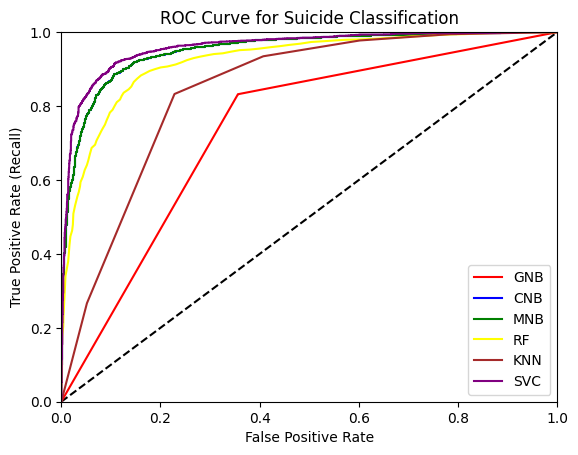

In [43]:
plot_roc_curve()
for model_name, y_pred in model_pred_dict.items():
    fpr_gnb,tpr_gnb,thresholds_gnb = roc_curve(y_train,y_pred)
    plt.plot(fpr_gnb,tpr_gnb,color = model_color_dict[model_name],label=model_name)
plt.legend(loc='lower right')
plt.show()

### ROC scores

In [44]:
print('ROC AUC scores:')
for model_name, y_pred in model_pred_dict.items():
    print(f'{model_name}: {roc_auc_score(y_train,y_pred):.3f}')

ROC AUC scores:
GNB: 0.738
CNB: 0.950
MNB: 0.950
RF: 0.923
KNN: 0.843
SVC: 0.960


### Classification Report

In [45]:
model_dict = {
    'GNB':gnb_clf,
    'CNB':cnb_clf,
    'MNB':mnb_clf,
    'RF':rf_clf,
    'KNN':knn_clf,
    'SVC':svc_clf
}

In [46]:
for model_name,model in model_dict.items():
    print(model_name)
    if model_name=='GNB':
        y_pred = cross_val_predict(model,X_train_vectorized.toarray(),y_train,cv=3)
    else:
        y_pred = cross_val_predict(model,X_train_vectorized,y_train,cv=3)
    print(classification_report(y_train,y_pred))


GNB
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      2011
           1       0.70      0.83      0.76      1989

    accuracy                           0.74      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.74      0.73      4000

CNB
              precision    recall  f1-score   support

           0       0.97      0.42      0.59      2011
           1       0.63      0.99      0.77      1989

    accuracy                           0.70      4000
   macro avg       0.80      0.71      0.68      4000
weighted avg       0.80      0.70      0.68      4000

MNB
              precision    recall  f1-score   support

           0       0.97      0.43      0.59      2011
           1       0.63      0.99      0.77      1989

    accuracy                           0.71      4000
   macro avg       0.80      0.71      0.68      4000
weighted avg       0.80      0.71      0.68      4000

RF
    

## Model selection
SVC model was selected due to highest ROC AUC, highest Recall, and highest F1 scores.

# Error analysis
[//]: # (-.- .tabset)

In [47]:
y_train_pred = cross_val_predict(svc_clf,X_train_vectorized,y_train,cv=3)

In [48]:
X_tp = X_train[(y_train == 1) & (y_train_pred == 1)]
X_fn = X_train[(y_train == 1) & (y_train_pred == 0)]
X_fp = X_train[(y_train == 0) & (y_train_pred == 1)]
X_tn = X_train[(y_train == 0) & (y_train_pred == 0)]

## False positives

In [49]:
X_fp.head()

,text
191,"Does anyone else feel like they were neglected by their parents just because you were never a problem child? I know this isn't really a thing to complain about, but i've always wondered if anyone else felt the same\n\nI wa thirdborn in my family and homeschooled for the first 10 years. My mother had to school my rwo older brothers before I came into the world and this whittled down my mothers patience. By the time I was needing to be schooled, my mother was already busy enough with my other brothers that she didn't have the capacity to give me very much attention. \n\nBy the time I was able to read well on my own, my mother would just plop a textbook down in front of me and I would go ahead and study on my own. I learned rather quickly that my mother had little patience when I asked for help twice in a row, or took too long to figure out easy stuff. Yelling and occasionally beatings would follow so I stopped asking for help altogether. \n\nFrom that point on, almost everything I did was on my own. I would start to fear help itself so I would kick my rear into overdrive and focus the hell out of my times tables or whatever it was that I was studying just to avoid help altogether. \n\nIt wasn't just with studying. I was for some strange reason really sensetive to yelling and I would prefer a beating rather than a scold on pretty much every occasion. Because of this, I learned cery quickly how to be a good boy in the house, not making any trouble whatsoever. Never causing problems and never having any that I had to ask assistance with.\n\nI had fun by myself in those times. Jigsaw puzzles and puzzle books and jacks and whatever other 1 player games I could find, I played them. Keeping all the possible problems I could cause to a minimum.\n\nA decade down the line, i'm now older and in high school. I do exceedingly well in every class and never cause a problem for anybody. I do find myself without a social life which I considered to be a waste of energy at the time. I've also noticed that all my exceptional achievements are going pretty much unseen by my parents. I believe that they just got used to how I was never a problen and now its standard in their eyes. I grew up always being great and pushing into greatness even further is exceedingly difficult.\n\nNow i'm 19 and I feel in sort of trapped in this image I created for my parents that I ""must always be perfect"" and ""never cause a problem"". I've worked so hard to keep this image but I feel like its tearing me down.\n\nI feel really down all the time now. I just feel so unmotivated and unhappy. The ""good boy"" in me says to ignore all that emotional bs and just keep moving along, but its harder and harder to do that every passing day. I just feel depressed. I hide it all from my parents because this would be an issue that I would be putting onto them. ""Sorry mom, but your 3rd child has a problem"". Also, I don't even know if theyll care.\n\nAnd looking back on this whole situation, I feel like I have only myself to blame. I feel like I was the one who caused my parents to not care about me because I never wanted them to care about me and I avoided it whereever I could.\n\nI'm the one who caused them to look at me the way they do. \n\nDoes anyone else feel the same?"
152,"my boyfriend is getting his wisdom teeth removed today so i wanted to make a cute post just raving about him and hopes he sees it but i doubt he will :) Well, he's asleep right now cause he hasn't replied to my messages but he deserves the rest, he'll be sleepy all day. \n\nAnyway...\n\nHe's so amazing. I love him so much, our 4 year anniversary is coming up on February 14. I got him his gift and it's currently in transit. I just wanted to say he's literally the most amazing thing to ever happen to me, I wouldn't be the person I am today without him. I... live in an extremely toxic home, and I hate it, I'm not allowed to date but I don't care, I fell in love with someone, and we've been togethe

In [50]:
X_fp['text'].str.len().describe()

count     161.000000
mean      755.459627
std       857.999279
min        25.000000
25%       204.000000
50%       448.000000
75%       991.000000
max      5212.000000
Name: text, dtype: float64

## False negatives

In [51]:
X_fn.head()

,text
3802,"I [20M] need help talking to my suicidal friend [20M] \n\nI \[20M\] currently share an apartment with my friend \[20M\], his brother \[20M\] and his girlfriend \[19F\].\n\nMy friend was talking to his girlfriend and I about her needing to find a hobby since she has free time that she doesn't know what to do with. She mentioned that he also needs to find another hobby which I agreed with as he recently and his brother recently dropped out of university (his girlfriend and I still attend) and all he does all day is play video games. I know that video games can be a fine hobby but it takes up his day from the time he wakes up to the time he goes to sleep. When I suggested that they find a hobby that they could do together he rejected the idea. When his girlfriend said that she wasn't fond of him playing video games for around 10-16 hours a day he said that it keeps his mind off of suicide and that she would have to deal with it until he gets better.\n\nHe doesn't go to any counselling that I'm aware of and doesn't leave the house all that often except for things like running to the corner store or the grocery store.\n\nNeither his brother nor his girlfriend are really in great mental places right now either so I'm not sure if they'll be up for having a serious talk with him.\n\nI'm worried about him but I'm not sure what I should do, any advice would be appreciated."
3017,Anyone who survived an attempt and looking for support?Not sure if this is the right sub. I'd like to get in touch with anyone that have survived an attempt. And talk if its okay. Thanks
205,"I found the location.Next step is to get the rope, and hold off till the date comes"
3830,Unlikely TopicsYou know what's unlikely? An unfunny drag queen. What do you think?
305,Relatives and suicideI know it's a sensitive topic but i'm interested in what it was like for people which had others in their family or close friend group commit suicide.


In [52]:
X_fn['text'].str.len().describe()

count     241.000000
mean      333.954357
std       456.490875
min        11.000000
25%        93.000000
50%       195.000000
75%       372.000000
max      3247.000000
Name: text, dtype: float64

## True negatives

In [53]:
X_tn.head()

,text
4193,"go ahead, call the cops they can’t unpog you anyways"
2968,"What are your ways of procrastinating on computers? I just want to know your ways, something other than the obvious playing games please"
4793,"How to know if you have ADHD so basically recently I have been having lots of trouble concentrating on stuff and idk why. I feel like I may have adhd or something because I thinks that’s what it is. Idk if this is adhd or if this is something else, if anyone knows how to tell if you have adhd let me know because idk how to explain to my teachers why I’m not able to finish my work because I cant concentrate. This might be a stupid/useless post but idk"
4368,"Do you ever wake up after moving thinking you still live in your old house and you wake up to the neighbors screaming at the top of their lungs in Portuguese and you’re like since when did the Finnegans learn Portuguese. And then it registers that your dad got transferred again and You moved to From the UK to Switzerland again, And the new neighbors are not the Finnegans you aren’t proficient in Portuguese yet so you have no idea what you’re saying plus the fact you’re 11 So outside of the unwelcome wake up call you really don’t give a shit...lol\n\n||||\n|:-|:-|:-|\n||||"
2970,just learned about Deuteronomy 23:2 wish i knew about it *BEFORE* i stuck my penis into a blender


In [54]:
X_tn['text'].str.len().describe()

count     1850.000000
mean       290.210811
std        511.301328
min         21.000000
25%         99.000000
50%        159.000000
75%        282.750000
max      12651.000000
Name: text, dtype: float64

## True positives

In [55]:
X_tp.head()

text
4227                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [56]:
X_tp['text'].str.len().describe()

count     1748.000000
mean      1102.780320
std       1220.164572
min         40.000000
25%        372.750000
50%        717.500000
75%       1389.000000
max      15669.000000
Name: text, dtype: float64

# Fine-tuning

## TfidfVectorizer Fine-tuning
[//]: # (-.- .tabset)
Lets try to fine-tune the TfidfVectorizer to see if we get better results. We will try the following parameter combinations:
* `ngram_range`: 
    1. (1,1)(default)
    2. (1,2)
    3. (1,3)
* `stop_words`: 
    1. english
    2. None(default)


### ngram=(1,1); stop_words='english'

In [73]:
vectorizer = TfidfVectorizer(ngram_range = (1,3),stop_words='english')
X_train_vectorized_n13_en = vectorizer.fit_transform(X_train['text'])
y_pred_n13_en = cross_val_predict(svc_clf,X_train_vectorized_n13_en,y_train,cv=3)
print(classification_report(y_train,y_pred_n13_en))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2011
           1       0.92      0.83      0.88      1989

    accuracy                           0.88      4000
   macro avg       0.89      0.88      0.88      4000
weighted avg       0.89      0.88      0.88      4000



Recall worse then baseline model

### ngram=(1,3); stop_words=None

In [57]:
vectorizer = TfidfVectorizer(ngram_range = (1,3))
X_train_vectorized_n13 = vectorizer.fit_transform(X_train['text'])
y_pred_n13 = cross_val_predict(svc_clf,X_train_vectorized_n13,y_train,cv=3)
print(classification_report(y_train,y_pred_n13))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2011
           1       0.92      0.83      0.87      1989

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



Recall worse then baseline model

### ngram=(1,1); stop_words='english'

In [58]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized_en = vectorizer.fit_transform(X_train['text'])
y_pred_en = cross_val_predict(svc_clf,X_train_vectorized_en,y_train,cv=3)
print(classification_report(y_train,y_pred_en))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2011
           1       0.92      0.86      0.89      1989

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



Recall better than baseline model

### ngram=(1,2); stop_words='english'

In [59]:
vectorizer = TfidfVectorizer(stop_words='english',ngram_range = (1,2))
X_train_vectorized_en = vectorizer.fit_transform(X_train['text'])
y_pred_en = cross_val_predict(svc_clf,X_train_vectorized_en,y_train,cv=3)
print(classification_report(y_train,y_pred_en))

              precision    recall  f1-score   support

           0       0.86      0.94      0.89      2011
           1       0.93      0.84      0.88      1989

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



Recall for non-suicide is better but for suicide group is worse.

### ngram=(1,2); stop_words=None

In [60]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))
X_train_vectorized_en = vectorizer.fit_transform(X_train['text'])
y_pred_en = cross_val_predict(svc_clf,X_train_vectorized_en,y_train,cv=3)
print(classification_report(y_train,y_pred_en))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2011
           1       0.93      0.85      0.89      1989

    accuracy                           0.89      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.90      0.89      0.89      4000



Recall for non-suicide is better but for suicide group is worse.

## SVC Fine-tuning
[//]: # (-.- .tabset)

'kernel' gamma c degree

In [ ]:
param_grid = {'kernel':[0.1, 1, 10, 100, 1000],
              'gamma':[1, 0.1, 0.01, 0.001, 0.0001],
               'C':['rbf'],
               'degree'

# Evaluate Model on the Test set

In [61]:
pip_clf_svc = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())])

In [63]:
X_train

,text
4227,"I might kill myself tomorrowLife is just too much. It just seems to be getting worse. I try so hard but nothing gets better! I cant think of anything but hurting myself. I just want to be dead. I cant take it any more. Im so useless, theres no reason for me to keep fighting."
4676,"I dont see things getting much betterClearly, if I'm posting here im not 100% wanting to die. In fact, I really wish life could be better for me. I just dont believe I will get better. My issues come from a lot of trauma, and I've been in therapy for more than 3 years. I consistently do things to try to better my life. I try to make healthier decisions, I try to be a better person, and I try to employ the ""fake it til you make it"" method of being happy (not in a disingenuous way just trying to make good habits). I have some good days. I have some comfortable and quiet days. I do not necessarily have happy days. And, more so than the former, I have a lot of really hard moments and days. \n\n\nI'm tired of feeling haunted. I'm tired of the hauntings always coming back, and always getting in the way. I feel like I'm doing everything I can, maybe I'm not, i dont know. But at what point is it just the rational decision to accept the reality of circumstance? There are plenty of people trapped to cycles of mindsets and behaviors they cannot change, or are almost incapable of changing. \n\n\nOn my best days, I do not believe in much besides biology and chance. Things have no meaning besides what you give them. If I were capable of feeling safe and comfortable, then I would be happy finding things that I have meaning in. And i try to do this. But I can't have the basic foundation of stability. On my worst days, I am convinced that the world, or at least my own world, is plagued with pain. The one thing I can believe in is pain. It is consistent and promised and not fake. I cannot believe in anything else as genuinely as I can pain. \n\n\nAt what point is limiting the amount of pain I continue to endure or encounter the more rational decision, rather than being a sitting duck waiting for the next trauma to come? Or the next affirmation that I cannot trust myself nor others? Or the next proof that there is no good around me. I dont want to wait for those things. My hauntings convince me those things are coming, whether they are or not. Which makes those things reality anyways. \n\n\nI'm tired of the moments where I feel completely despaired and fearful. Not even entirely sure what my body and mind are dreading most of the time, sometimes my mind just rationalizes that intense fear by creating paranoid thoughts. And then I lose my sense of self and reality even more. It's awful to have flashbacks and nightmares and then paranoia. Its awful to believe everything can and will hurt me. I'm tired."
800,"Scared sister is going to do itMy dad and my sister have never been good friends. Today they started screaming at each other, my sister started swearing (we're Christians) and my dad tried to hit my sister (but I stopped him). She said she couldn't take it anymore and ran to her room. I'm scared out of my life that she's going to kill herself. What do/can I do?"
3671,"Leaving for a while?Hi people. So yeah I've been thinking about blowing my head off with a 12 gauge for years now. Well any ways, I've been thinking that I might as well delay such actions and try and do something interesting. I'm thinking about just packing a whole bunch of shit into my car and leaving. Quitting my job, dropping out of school, and just driving somewhere else. Or maybe even leave the country. Thinking about cutting contact with everyone I know. My parents are paying for my college right now and would be pissed about me wasting their money. However, I feel like they would rather have me gone and their money wasted than a dead son. I'm hoping such a trip will allow me to find some satisfaction and enjoyment out of life. Is this a good idea? Have any of you ever tried someth

In [62]:
pip_clf_svc.fit(X_train,y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1, 4000]

In [ ]:
predictSVC = svc_clf.predict(X_test_vectorized)
print(f'SVC accuracy score: {accuracy_score(y_test,predictSVC):.2f}')
print(f'SVC ROC AUC score: {roc_auc_score(y_test,predictSVC):.2f}')

In [ ]:
msg = 'some example post'
pipeSVC.predict([msg])